# Project Notebook

### Importing Libraries

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from openpyxl import load_workbook

## 1. Import Datasets

In [110]:
# main data set
data_main = pd.read_csv('data/cancer_reg.csv', encoding = "ISO-8859-1")

# import data of manufactoring share
wb = load_workbook('data/industry_county_data_overview.xlsx', data_only=True)
ws = wb['new_overview']
ws_data = ws.values
# Get the first line in file as a header line
columns = next(ws_data)[0:]
# Create a DataFrame based on the second and subsequent lines of data
data_industry = pd.DataFrame(ws_data, columns=columns)

# import data of UV exposure
data_uv = pd.read_csv('data/uv-county.csv', encoding = "ISO-8859-1")

# import data with rural/urban classification
data_county_class = pd.read_excel('data/PctUrbanRural_County.xls', sheet_name='Pct urban by county')


In [111]:
data_industry = data_industry[['county_state', 'Industry Share of County GDP (Manufacturing)', 'Industry Share of County GDP (Mining, Oil, Gas)']]
data_industry

,county_state,Industry Share of County GDP (Manufacturing),"Industry Share of County GDP (Mining, Oil, Gas)"
0,Autauga_AL,0.15095,0.019244
1,Baldwin_AL,0.068274,0.002761
2,Barbour_AL,0.261618,0.088787
3,Bibb_AL,0.119731,0.030386
4,Blount_AL,0.12457,0.004438
...,...,...,...
3112,Sweetwater_WY,0.110247,0.433276
3113,Teton_WY,0.009897,0.003029
3114,Uinta_WY,0.041912,0.102798
3115,Washakie_WY,0.153798,0.048576


## 2. Data Cleaning
## 2.1 Harmonize county names

### Lower case for all column names

In [112]:
data_main.columns=[item.lower() for item in data_main.columns]
data_industry.columns=[item.lower() for item in data_industry.columns]
data_uv.columns=[item.lower() for item in data_uv.columns]
data_county_class.columns=[item.lower() for item in data_county_class]

In [113]:
#data_main.geography.to_csv('county_check.csv')

In [114]:
# Extract county name from Geography
# data_main['county'] = data_main.geography.str.split(' County', expand=True)[0]
def get_countyname(item):
    if ' County' in item:
        return item[:item.find(' County')]
    elif ' Parish' in item:
        return item[:item.find(' Parish')]
    #elif ' city' in item:
    #    return item[:item.find(' city')]
    else:
        return item[:item.find(',')]

data_main['county'] =  data_main.geography.apply(get_countyname)
# Extract state name from Geography
data_main['state'] = data_main.geography.str.split(', ').str[1]

In [115]:
data_main.state

0       Washington
1       Washington
2       Washington
3       Washington
4       Washington
           ...    
3042        Kansas
3043        Kansas
3044        Kansas
3045        Kansas
3046        Kansas
Name: state, Length: 3047, dtype: object

In [116]:
# read state abbreviation lookup table
wb2 = load_workbook('data/state_abbreviations.xlsx')
ws2 = wb2['Sheet1']
ws_data2 = ws2.values
# Get the first line in file as a header line
columns2 = next(ws_data2)[0:]
# Create a DataFrame based on the second and subsequent lines of data
state_abb = pd.DataFrame(ws_data2, columns=columns2)

In [117]:
state_abb.head()

,state,state_short
0,ALABAMA,AL
1,ALASKA,AK
2,AMERICAN SAMOA,AS
3,ARIZONA,AZ
4,ARKANSAS,AR


In [118]:
# capitalize state names in lookup table
state_abb.state = state_abb.state.str.title()
# Correct this for DC
state_abb.state = state_abb.state.str.replace('District Of Columbia','District of Columbia')

### Merge main table with lookup table

In [119]:
# merge
data_main = pd.merge(data_main, state_abb, how='left', on='state')

In [120]:
print(sorted(data_main.state.unique()))
print(sorted(state_abb.state.unique()))

['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana

### Create new column which consists of county and state name

In [121]:
# New combined column
data_main['county_state'] = data_main['county'].map(str) + '_' + data_main['state_short'].map(str)
data_main.county_state

0          Kitsap_WA
1        Kittitas_WA
2       Klickitat_WA
3           Lewis_WA
4         Lincoln_WA
            ...     
3042    Ellsworth_KS
3043       Finney_KS
3044         Ford_KS
3045     Franklin_KS
3046        Geary_KS
Name: county_state, Length: 3047, dtype: object

In [122]:
# check for duplicates
data_main.geography[data_main.county_state.duplicated(keep=False) == True]

Series([], Name: geography, dtype: object)

### Harmonize data_industry table

In [123]:
data_industry.head()

,county_state,industry share of county gdp (manufacturing),"industry share of county gdp (mining, oil, gas)"
0,Autauga_AL,0.15095,0.019244
1,Baldwin_AL,0.068274,0.002761
2,Barbour_AL,0.261618,0.088787
3,Bibb_AL,0.119731,0.030386
4,Blount_AL,0.12457,0.004438


In [124]:
# kick out asterisks and (independent city from county)
data_industry.county_state = data_industry.county_state.str.replace(', ','_', regex=False)
data_industry.county_state = data_industry.county_state.str.replace('*','', regex=False)
data_industry.county_state = data_industry.county_state.str.replace('(Independent City)','city', regex=False)
data_industry.county_state = data_industry.county_state.str.replace('(city)','city', regex=False)
# rename columns
data_industry.rename(columns={"industry share of county gdp (manufacturing)": "industry_share_manufacturing", "industry share of county gdp (mining, oil, gas)": "industry_share_mineoilgas"}, inplace=True)

### Harmonize data_uv table

In [125]:
data_uv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3108 entries, 0 to 3107
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   statename    3108 non-null   object
 1   state_abr    3108 non-null   object
 2   county_fips  3108 non-null   int64 
 3   county name  3108 non-null   object
 4   uv_ wh/m_    3108 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 121.5+ KB


In [126]:
# Create new Column county_state
data_uv['county_state'] = data_uv['county name'].map(str) + '_' + data_uv['state_abr'].map(str)
data_uv['county_state']

0          Autauga_AL
1          Baldwin_AL
2          Barbour_AL
3             Bibb_AL
4           Blount_AL
            ...      
3103    Sweetwater_WY
3104         Teton_WY
3105         Uinta_WY
3106      Washakie_WY
3107        Weston_WY
Name: county_state, Length: 3108, dtype: object

In [127]:
# Rename column
data_uv.rename(columns={"uv_ wh/m_": "uv"}, inplace=True)

# dropping unnessessary columns
data_uv = data_uv[['county_state','uv']]
data_uv.head()

,county_state,uv
0,Autauga_AL,4563
1,Baldwin_AL,4492
2,Barbour_AL,4642
3,Bibb_AL,4499
4,Blount_AL,4416


### Harmonize data_county_class table

In [128]:
data_county_class

,state,county,statename,countyname,pop_cou,area_cou,pop_urban,poppct_urban,area_urban,areapct_urban,...,pop_uc,poppct_uc,area_uc,areapct_uc,popden_uc,pop_rural,poppct_rural,area_rural,areapct_rural,popden_rural
0,1,1,Alabama,Autauga,54571,1539582278,31650,58.00,50882539,3.30,...,0,0.00,0,0.00,NaN,22921,42.00,1488699739,96.70,39.9
1,1,3,Alabama,Baldwin,182265,4117521611,105205,57.72,275001368,6.68,...,41556,22.80,111381848,2.71,966.3,77060,42.28,3842520243,93.32,51.9
2,1,5,Alabama,Barbour,27457,2291818968,8844,32.21,17447656,0.76,...,8844,32.21,17447656,0.76,1312.8,18613,67.79,2274371312,99.24,21.2
3,1,7,Alabama,Bibb,22915,1612480789,7252,31.65,18903236,1.17,...,7252,31.65,18903236,1.17,993.6,15663,68.35,1593577553,98.83,25.5
4,1,9,Alabama,Blount,57322,1669961855,5760,10.05,10874700,0.65,...,5374,9.38,9851721,0.59,1412.8,51562,89.95,1659087155,99.35,80.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,72,145,Puerto Rico,Vega Baja,59662,118766810,57170,95.82,72771265,61.27,...,0,0.00,0,0.00,NaN,2492,4.18,45995545,38.73,140.3
3217,72,147,Puerto Rico,Vieques,9301,131488427,8230,88.49,13439063,10.22,...,8230,88.49,13439063,10.22,1586.1,1071,11.51,118049364,89.78,23.5
3218,72,149,Puerto Rico,Villalba,26073,92298550,22564,86.54,39316802,42.60,...,0,0.00,0,0.00,NaN,3509,13.46,52981748,57.40,171.5
3219,72,151,Puerto Rico,Yabucoa,37941,143005172,32192,84.85,62090343,43.42,...,0,0.00,0,0.00,NaN,5749,15.15,80914829,56.58,184.0


In [129]:
# drop state column which contains a number
data_county_class.drop('state', axis=1, inplace = True)
# rename the statename column
data_county_class.rename(columns={'statename': 'state'}, inplace=True)

In [130]:
# merge with abbreviation table
data_county_class = pd.merge(data_county_class, state_abb, how='left', on='state')

In [131]:
# Create new Column county_state
data_county_class['county_state'] = data_county_class['countyname'].map(str) + '_' + data_county_class['state_short'].map(str)
data_county_class['county_state']

0         Autauga_AL
1         Baldwin_AL
2         Barbour_AL
3            Bibb_AL
4          Blount_AL
            ...     
3216    Vega Baja_PR
3217      Vieques_PR
3218     Villalba_PR
3219      Yabucoa_PR
3220        Yauco_PR
Name: county_state, Length: 3221, dtype: object

In [132]:
# Drop unnessessary columns
data_county_class = data_county_class[['county_state','poppct_urban', 'poppct_rural']]
data_county_class.head()

,county_state,poppct_urban,poppct_rural
0,Autauga_AL,58.00,42.00
1,Baldwin_AL,57.72,42.28
2,Barbour_AL,32.21,67.79
3,Bibb_AL,31.65,68.35
4,Blount_AL,10.05,89.95


In [133]:
# Look for duplicates
data_county_class[data_county_class.county_state.duplicated(keep=False)]

,county_state,poppct_urban,poppct_rural
1195,Baltimore_MD,93.47,6.53
1216,Baltimore_MD,100.00,0.00
1578,St. Louis_MO,98.86,1.14
1597,St. Louis_MO,100.00,0.00
2829,Bedford_VA,21.57,78.43
2848,Fairfax_VA,98.61,1.39
2852,Franklin_VA,10.77,89.23
2895,Richmond_VA,0.00,100.00
2896,Roanoke_VA,81.46,18.54
2916,Bedford_VA,97.94,2.06


In [134]:
# Manually change the counties that are actually cities
data_county_class.iloc[1216, data_county_class.columns.get_loc('county_state')] = 'Baltimore city_MD'
data_county_class.iloc[1578, data_county_class.columns.get_loc('county_state')] = 'St. Louis city_MO'
data_county_class.iloc[2916, data_county_class.columns.get_loc('county_state')] = 'Bedford city_VA'
data_county_class.iloc[2925, data_county_class.columns.get_loc('county_state')] = 'Fairfax city_VA'
data_county_class.iloc[2927, data_county_class.columns.get_loc('county_state')] = 'Franklin city_VA'
data_county_class.iloc[2945, data_county_class.columns.get_loc('county_state')] = 'Richmond city_VA'
data_county_class.iloc[2946, data_county_class.columns.get_loc('county_state')] = 'Roanoke city_VA'

## 2.2 Data Joining

### Join data_main with data_industry

In [135]:
data_main = pd.merge(data_main, data_industry, how='left', on='county_state')

In [136]:
data_main[(data_main.industry_share_manufacturing.isna() == True)].count

<bound method DataFrame.count of       avganncount  avgdeathsperyear  target_deathrate  incidencerate  \
127   1962.667684               145             193.5     453.549422   
216    309.000000               120             153.3     396.200000   
225    346.000000               156             176.8     399.000000   
228    155.000000                59             172.1     437.000000   
229   1142.000000               407             150.1     373.700000   
233    493.000000               204             155.9     400.500000   
234    115.000000                58             159.2     338.000000   
235    378.000000               157             156.1     400.200000   
240     97.000000                43             181.8     405.700000   
241    518.000000               191             172.5     449.400000   
247    312.000000               136             176.7     420.800000   
249    176.000000               106             223.4     367.300000   
251    272.000000              

### Fill missing values for industry share with mean share of respective state

In [137]:
data_main['industry_share_manufacturing'] = data_main['industry_share_manufacturing'].fillna(data_main.groupby('state')['industry_share_manufacturing'].transform('mean'))
data_main['industry_share_mineoilgas'] = data_main['industry_share_mineoilgas'].fillna(data_main.groupby('state')['industry_share_mineoilgas'].transform('mean'))
data_main.industry_share_manufacturing.value_counts(dropna = False)

0.000000    295
0.142449     42
0.025427      1
0.152833      1
0.145394      1
           ... 
0.017131      1
0.025018      1
0.014692      1
0.004929      1
0.027242      1
Name: industry_share_manufacturing, Length: 2712, dtype: int64

### Join data_main with data_uv

In [138]:
data_main = pd.merge(data_main, data_uv, how='left', on='county_state')
data_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3053 entries, 0 to 3052
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avganncount                   3053 non-null   float64
 1   avgdeathsperyear              3053 non-null   int64  
 2   target_deathrate              3053 non-null   float64
 3   incidencerate                 3053 non-null   float64
 4   medincome                     3053 non-null   int64  
 5   popest2015                    3053 non-null   int64  
 6   povertypercent                3053 non-null   float64
 7   studypercap                   3053 non-null   float64
 8   binnedinc                     3053 non-null   object 
 9   medianage                     3053 non-null   float64
 10  medianagemale                 3053 non-null   float64
 11  medianagefemale               3053 non-null   float64
 12  geography                     3053 non-null   object 
 13  avg

In [139]:
data_main[(data_main['uv'].isna() == True)].count

<bound method DataFrame.count of       avganncount  avgdeathsperyear  target_deathrate  incidencerate  \
166         799.0               319             150.8          381.0   
254         405.0               165             135.4          317.6   
255          64.0                58             226.6          265.7   
256          46.0                19             240.8          578.2   
257         250.0                60             178.2          718.9   
258         995.0               378             182.2          458.3   
259         117.0                43             159.3          493.6   
260         320.0               130             207.4          539.0   
261          55.0                16             137.6          447.7   
262          51.0                25             221.7          468.0   
263         120.0                39             180.3          566.3   
264         709.0               270             190.3          491.9   
265         190.0              

### Fill missing values for UV with mean share of respective state

In [140]:
data_main['uv'] = data_main['uv'].fillna(data_main.groupby('state')['uv'].transform('mean'))
data_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3053 entries, 0 to 3052
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avganncount                   3053 non-null   float64
 1   avgdeathsperyear              3053 non-null   int64  
 2   target_deathrate              3053 non-null   float64
 3   incidencerate                 3053 non-null   float64
 4   medincome                     3053 non-null   int64  
 5   popest2015                    3053 non-null   int64  
 6   povertypercent                3053 non-null   float64
 7   studypercap                   3053 non-null   float64
 8   binnedinc                     3053 non-null   object 
 9   medianage                     3053 non-null   float64
 10  medianagemale                 3053 non-null   float64
 11  medianagefemale               3053 non-null   float64
 12  geography                     3053 non-null   object 
 13  avg

In [141]:
data_main[(data_main['uv'].isna() == True)].head()

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,...,pctotherrace,pctmarriedhouseholds,birthrate,county,state,state_short,county_state,industry_share_manufacturing,industry_share_mineoilgas,uv
2318,911.0,343,147.6,402.7,51887,196428,18.1,0.000000,"(51046.4, 54545.6]",41.1,...,2.082702,47.978416,6.030934,Hawaii,Hawaii,HI,Hawaii_HI,0.000000,0.000049,NaN
2319,4646.0,1562,135.0,425.2,73985,998714,9.8,708.911660,"(61494.5, 125635]",36.9,...,0.915383,52.713161,6.457474,Honolulu,Hawaii,HI,Honolulu_HI,0.025372,0.001251,NaN
2320,326.0,130,149.4,392.2,58883,71735,12.3,655.189238,"(54545.6, 61494.5]",41.6,...,0.665796,54.706539,4.798814,Kauai,Hawaii,HI,Kauai_HI,0.000000,0.001090,NaN
2321,734.0,247,139.9,418.3,64916,164637,13.1,103.257469,"(61494.5, 125635]",40.0,...,0.870927,50.799618,6.347296,Maui,Hawaii,HI,Maui_HI,0.008457,0.000797,NaN
2719,8.0,3,203.3,201.3,68387,5702,9.9,0.000000,"(61494.5, 125635]",36.8,...,5.295567,42.882250,4.391052,Aleutians West Census Area,Alaska,AK,Aleutians West Census Area_AK,0.419544,0.023742,NaN


It seems like Alaska and Hawaii are missing in the UV table. I'll later decide if I kick both states from the dataset or kick the UV numbers instead.

### Join data_main with data_county_class

In [142]:
data_main = pd.merge(data_main, data_county_class, how='left', on='county_state')
data_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3053 entries, 0 to 3052
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avganncount                   3053 non-null   float64
 1   avgdeathsperyear              3053 non-null   int64  
 2   target_deathrate              3053 non-null   float64
 3   incidencerate                 3053 non-null   float64
 4   medincome                     3053 non-null   int64  
 5   popest2015                    3053 non-null   int64  
 6   povertypercent                3053 non-null   float64
 7   studypercap                   3053 non-null   float64
 8   binnedinc                     3053 non-null   object 
 9   medianage                     3053 non-null   float64
 10  medianagemale                 3053 non-null   float64
 11  medianagefemale               3053 non-null   float64
 12  geography                     3053 non-null   object 
 13  avg

## 2.3 Data transforming

### Check data types

In [143]:
data_main.describe()

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,...,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate,industry_share_manufacturing,industry_share_mineoilgas,uv,poppct_urban,poppct_rural
count,3053.000000,3053.000000,3053.000000,3053.000000,3053.000000,3.053000e+03,3053.000000,3053.000000,3053.000000,3053.000000,...,3053.000000,3053.000000,3053.000000,3053.000000,3053.000000,3053.000000,3053.000000,3031.000000,3053.000000,3053.000000
mean,610.126938,187.363249,178.626728,448.245228,47098.507697,1.034629e+05,16.868031,155.342205,45.264887,39.571471,...,9.123786,1.262336,1.982211,51.245417,5.640925,0.142743,0.046957,4297.953606,41.928238,58.071765
std,1421.266302,505.932866,27.746053,54.535801,12094.325334,3.299452e+05,6.410199,529.143026,45.260401,5.222515,...,14.530692,2.627900,3.514961,6.569959,1.984728,0.132637,0.129821,419.057080,31.207262,31.207260
min,6.000000,3.000000,59.700000,201.300000,22640.000000,8.270000e+02,3.200000,0.000000,22.300000,22.400000,...,0.000000,0.000000,0.000000,22.992490,0.000000,0.000000,0.000000,3012.000000,0.000000,0.000000
25%,76.000000,28.000000,161.200000,420.300000,38887.000000,1.170300e+04,12.100000,0.000000,37.700000,36.400000,...,0.621371,0.254714,0.295421,47.756410,4.523580,0.038605,0.000261,3959.000000,15.160000,32.930000
50%,171.000000,62.000000,178.100000,453.549422,45219.000000,2.677700e+04,15.900000,0.000000,41.000000,39.600000,...,2.274510,0.550796,0.826185,51.669941,5.381478,0.110233,0.002693,4270.000000,41.090000,58.910000
75%,519.000000,149.000000,195.200000,480.800000,52513.000000,6.887900e+04,20.400000,83.840677,44.000000,42.500000,...,10.530371,1.223758,2.176268,55.396115,6.491885,0.210747,0.018307,4571.000000,67.070000,84.840000
max,38150.000000,14010.000000,362.800000,1206.900000,125635.000000,1.017029e+07,47.400000,9762.308998,624.000000,64.700000,...,85.947799,42.619425,41.930251,78.075397,21.326165,0.894266,0.978804,5723.000000,100.000000,100.000000


In [144]:
# Harmonize percentages
data_main.industry_share_manufacturing = data_main.industry_share_manufacturing * 100
data_main.industry_share_mineoilgas = data_main.industry_share_mineoilgas * 100

### Check for missing values

In [145]:
data_main.isna().sum()

avganncount                        0
avgdeathsperyear                   0
target_deathrate                   0
incidencerate                      0
medincome                          0
popest2015                         0
povertypercent                     0
studypercap                        0
binnedinc                          0
medianage                          0
medianagemale                      0
medianagefemale                    0
geography                          0
avghouseholdsize                   0
percentmarried                     0
pctnohs18_24                       0
pcths18_24                         0
pctsomecol18_24                 2290
pctbachdeg18_24                    0
pcths25_over                       0
pctbachdeg25_over                  0
pctemployed16_over               152
pctunemployed16_over               0
pctprivatecoverage                 0
pctprivatecoveragealone          611
pctempprivcoverage                 0
pctpubliccoverage                  0
p

### Fill missing values for the column pctsomecol 18-24

In [146]:
#data_main.to_csv('export for tableau.csv')
data_main['pctsomecol18_24'] = data_main['pctsomecol18_24'].fillna(100 - data_main['pctnohs18_24'] - data_main['pcths18_24'] - data_main['pctbachdeg18_24'])

### Filling missing values for pctemployed16_over

In [147]:
# Create a statewide ratio between employed and unemployed
data_main['ratioemployment'] = data_main.groupby('state')['pctemployed16_over'].transform('mean')/data_main.groupby('state')['pctunemployed16_over'].transform('mean')
data_main['ratioemployment']

0        5.829581
1        5.829581
2        5.829581
3        5.829581
4        5.829581
          ...    
3048    13.217273
3049    13.217273
3050    13.217273
3051    13.217273
3052    13.217273
Name: ratioemployment, Length: 3053, dtype: float64

In [148]:
# Fill the missing values with the product of pctunemployed & ratioemployment
data_main['pctemployed16_over'] = data_main['pctemployed16_over'].fillna(data_main['pctunemployed16_over'] * data_main['ratioemployment'])

In [149]:
data_main[['pctemployed16_over','pctunemployed16_over']].head(20)

,pctemployed16_over,pctunemployed16_over
0,51.900000,8.0
1,55.900000,7.8
2,45.900000,7.0
3,48.300000,12.1
4,48.200000,4.8
5,44.100000,12.9
6,51.800000,8.9
7,40.900000,8.9
8,39.500000,10.3
9,56.600000,9.2


### Fill missing values for pctprivatecoveragealone

<AxesSubplot:xlabel='pctprivatecoveragealone', ylabel='pctempprivcoverage'>

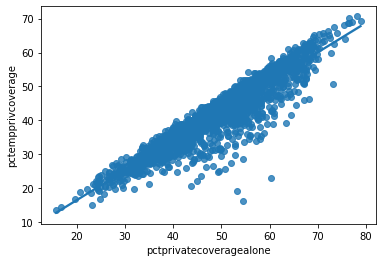

In [150]:
# Draw a scatterplott
sns.regplot(x=data_main["pctprivatecoveragealone"], y=data_main["pctempprivcoverage"])

There seems to be a correlation between pctprivatecoveragealone and pctempprivatecoverage exept for some outliers

In [151]:
# Create a statewide ratio between both variables
data_main['ratiocoverage'] = data_main.groupby('state')['pctprivatecoveragealone'].transform('mean')/data_main.groupby('state')['pctempprivcoverage'].transform('mean')
data_main['ratiocoverage']

0       1.208875
1       1.208875
2       1.208875
3       1.208875
4       1.208875
          ...   
3048    1.226752
3049    1.226752
3050    1.226752
3051    1.226752
3052    1.226752
Name: ratiocoverage, Length: 3053, dtype: float64

In [152]:
# Fill the missing values with the product of pctempprivcoverage & ratiocoverage
data_main['pctprivatecoveragealone'] = data_main['pctprivatecoveragealone'].fillna(data_main['pctempprivcoverage'] * data_main['ratiocoverage'])

In [153]:
data_main[['pctprivatecoveragealone','pctempprivcoverage']].head(20)

,pctprivatecoveragealone,pctempprivcoverage
0,50.289207,41.6
1,53.800000,43.6
2,43.500000,34.9
3,40.300000,35.0
4,43.900000,35.1
5,38.800000,32.6
6,35.000000,28.3
7,33.100000,25.9
8,37.800000,29.9
9,53.674058,44.4


## 3. Data Exploring

## 3.1 Check for correlations

In [154]:
# Move numericals to dedicated dataframe
numerical = data_main.select_dtypes('number')

In [155]:
# calculate new Dataframe with correllation factors
corr_df = numerical.corr().abs()
corr_df

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,medianage,medianagemale,...,pctotherrace,pctmarriedhouseholds,birthrate,industry_share_manufacturing,industry_share_mineoilgas,uv,poppct_urban,poppct_rural,ratioemployment,ratiocoverage
avganncount,1.000000,0.939918,0.144951,0.073584,0.273397,0.927175,0.138545,0.082352,0.024377,0.125670,...,0.208159,0.106485,0.035195,0.048441,0.086739,0.001416,0.382471,0.382471,0.004333,0.080947
avgdeathsperyear,0.939918,1.000000,0.092301,0.062896,0.227594,0.977339,0.070157,0.063840,0.024874,0.148995,...,0.213940,0.160399,0.074890,0.042282,0.090827,0.008356,0.421055,0.421055,0.116253,0.116152
target_deathrate,0.144951,0.092301,1.000000,0.449761,0.429781,0.122027,0.430162,0.022199,0.004520,0.021795,...,0.189849,0.293685,0.087195,0.176478,0.027988,0.072103,0.152400,0.152399,0.295772,0.247617
incidencerate,0.073584,0.062896,0.449761,1.000000,0.002983,0.026543,0.009644,0.077462,0.018113,0.014901,...,0.208821,0.152969,0.118056,0.168961,0.167899,0.309579,0.101255,0.101255,0.081164,0.177092
medincome,0.273397,0.227594,0.429781,0.002983,1.000000,0.241014,0.788096,0.043892,0.013641,0.092321,...,0.083946,0.444700,0.010885,0.050322,0.019435,0.171143,0.371444,0.371444,0.255651,0.014595
popest2015,0.927175,0.977339,0.122027,0.026543,0.241014,1.000000,0.068460,0.055993,0.025500,0.177156,...,0.240801,0.127573,0.058221,0.048173,0.079033,0.040640,0.393590,0.393590,0.098813,0.090328
povertypercent,0.138545,0.070157,0.430162,0.009644,0.788096,0.068460,1.000000,0.055694,0.029052,0.213342,...,0.047080,0.604123,0.011723,0.025705,0.000618,0.267619,0.141212,0.141212,0.414858,0.066160
studypercap,0.082352,0.063840,0.022199,0.077462,0.043892,0.055993,0.055694,1.000000,0.026040,0.036846,...,0.015193,0.051932,0.010474,0.009157,0.066220,0.069251,0.114714,0.114714,0.080641,0.009041
medianage,0.024377,0.024874,0.004520,0.018113,0.013641,0.025500,0.029052,0.026040,1.000000,0.129130,...,0.030274,0.014492,0.008260,0.014353,0.000167,0.025663,0.061148,0.061148,0.007175,0.032535
medianagemale,0.125670,0.148995,0.021795,0.014901,0.092321,0.177156,0.213342,0.036846,0.129130,1.000000,...,0.266810,0.222406,0.103784,0.062164,0.043833,0.212213,0.504433,0.504433,0.109727,0.072598


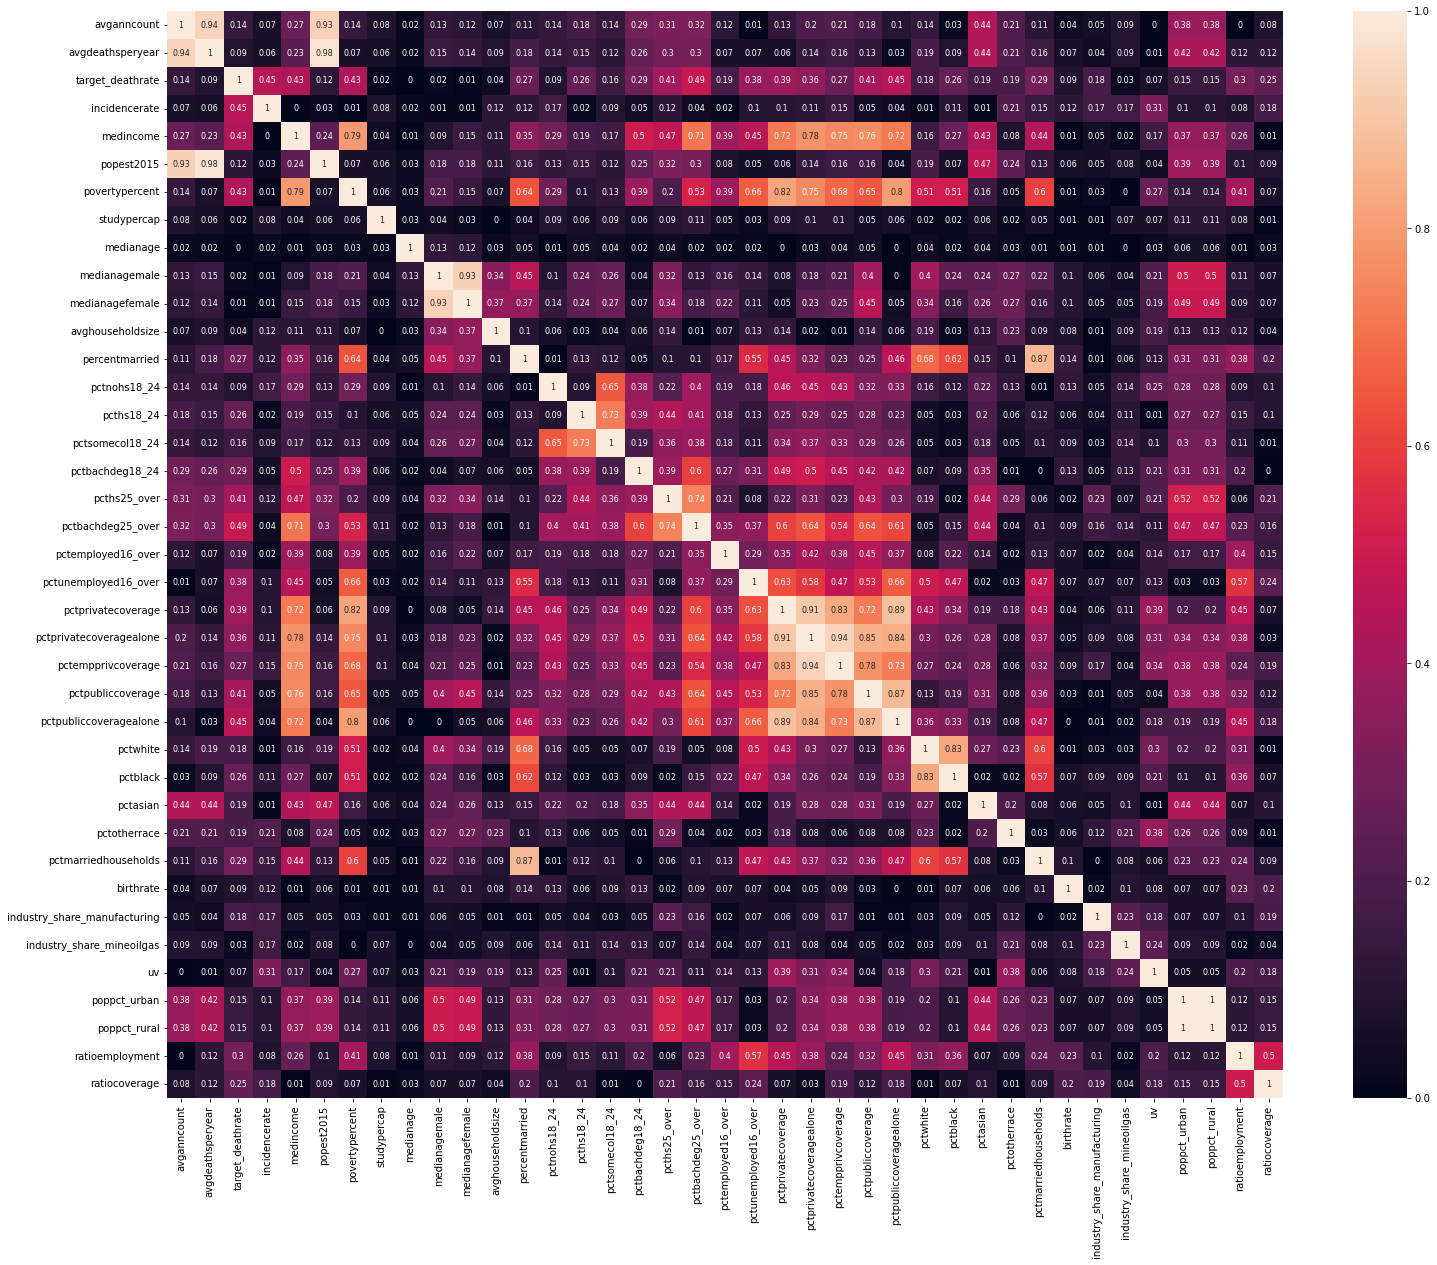

In [156]:
# Plot correlation heatmap
fig = plt.figure(figsize = (25,20))
ax = sns.heatmap(corr_df.round(2), annot=True, annot_kws={"size": 8})

### Filtering out highly correlated features

In [157]:
# Select upper traingular
upper_tri = corr_df.where(np.triu(np.ones(corr_df.shape),k=1).astype(np.bool_))
# Save highly correlating features r>0.9 in the list to_drop
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
# Drop the features from the to_drop list and create a reduced DataFrame
reduced_df = numerical.drop(numerical[to_drop], axis=1)

print("The reduced dataframe has {} columns.".format(reduced_df.shape[1]))

The reduced dataframe has 33 columns.


In [158]:
to_drop

['avgdeathsperyear',
 'popest2015',
 'medianagefemale',
 'pctprivatecoveragealone',
 'pctempprivcoverage',
 'poppct_rural']

## 3.1 Building graphs

### Histograms

C:\Users\flanc\AppData\Local\Temp/ipykernel_3388/3306283368.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  reduced_df.hist(ax = ax)


array([[<AxesSubplot:title={'center':'avganncount'}>,
        <AxesSubplot:title={'center':'target_deathrate'}>,
        <AxesSubplot:title={'center':'incidencerate'}>,
        <AxesSubplot:title={'center':'medincome'}>,
        <AxesSubplot:title={'center':'povertypercent'}>,
        <AxesSubplot:title={'center':'studypercap'}>],
       [<AxesSubplot:title={'center':'medianage'}>,
        <AxesSubplot:title={'center':'medianagemale'}>,
        <AxesSubplot:title={'center':'avghouseholdsize'}>,
        <AxesSubplot:title={'center':'percentmarried'}>,
        <AxesSubplot:title={'center':'pctnohs18_24'}>,
        <AxesSubplot:title={'center':'pcths18_24'}>],
       [<AxesSubplot:title={'center':'pctsomecol18_24'}>,
        <AxesSubplot:title={'center':'pctbachdeg18_24'}>,
        <AxesSubplot:title={'center':'pcths25_over'}>,
        <AxesSubplot:title={'center':'pctbachdeg25_over'}>,
        <AxesSubplot:title={'center':'pctemployed16_over'}>,
        <AxesSubplot:title={'center':'pctu

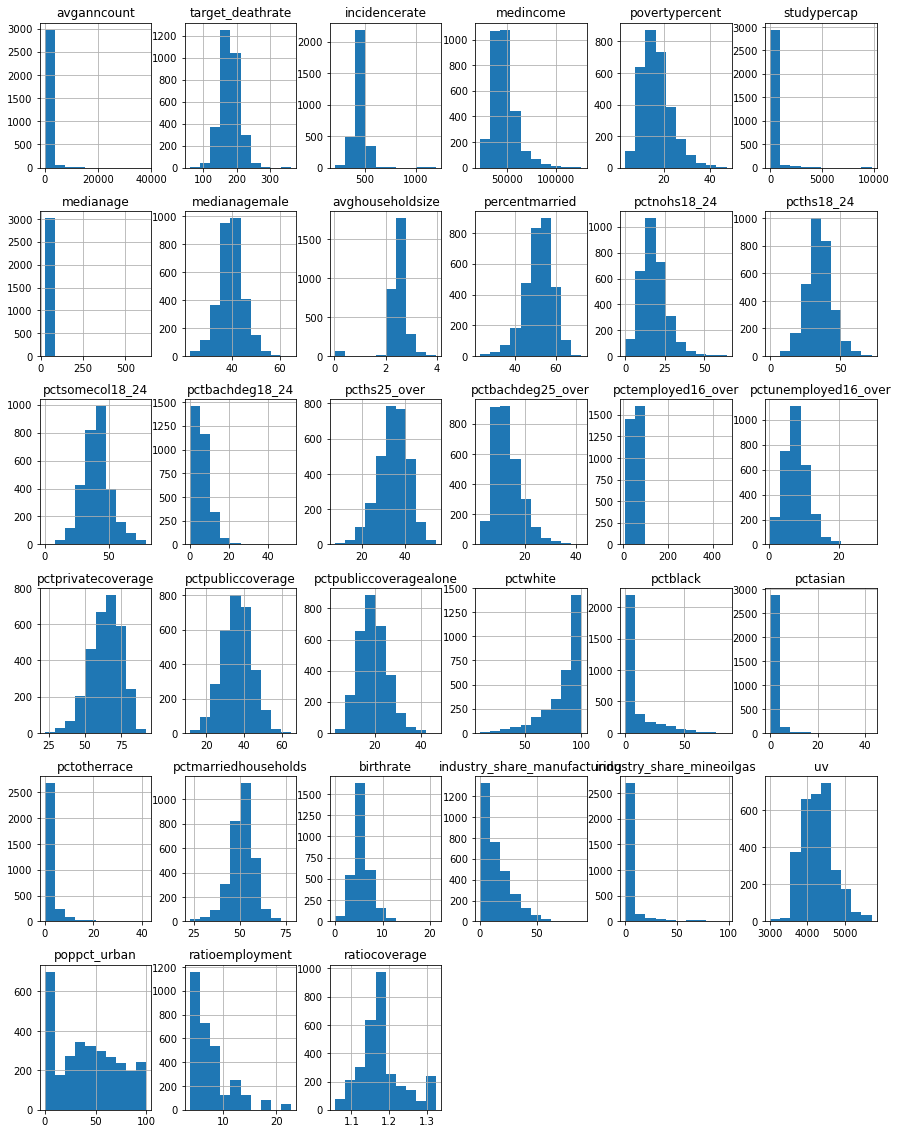

In [159]:
   fig = plt.figure(figsize = (15,20))
   ax = fig.gca()
   reduced_df.hist(ax = ax)

### Pairplots

In [160]:
# Pairplot for each numerical column
#sns.pairplot(numerical)

## 3.3 Outliers
### Checking for Outliers

In [161]:
Q1 = numerical.quantile(0.25)
Q3 = numerical.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

avganncount                       443.000000
avgdeathsperyear                  121.000000
target_deathrate                   34.000000
incidencerate                      60.500000
medincome                       13626.000000
popest2015                      57176.000000
povertypercent                      8.300000
studypercap                        83.840677
medianage                           6.300000
medianagemale                       6.100000
medianagefemale                     6.200000
avghouseholdsize                    0.260000
percentmarried                      8.700000
pctnohs18_24                        9.900000
pcths18_24                         11.500000
pctsomecol18_24                    12.800000
pctbachdeg18_24                     5.100000
pcths25_over                        9.200000
pctbachdeg25_over                   6.700000
pctemployed16_over                 12.100000
pctunemployed16_over                4.200000
pctprivatecoverage                 14.900000
pctprivate

### Deleting Outliers from DataFrame

In [162]:
numerical_o = numerical[~((numerical < (Q1 - 3 * IQR)) |(numerical > (Q3 + 3 * IQR))).any(axis=1)]
print(numerical.shape)
print(numerical_o.shape)

(3053, 39)
(1577, 39)


C:\Users\flanc\AppData\Local\Temp/ipykernel_3388/1224258567.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  numerical_o.hist(ax = ax)


array([[<AxesSubplot:title={'center':'avganncount'}>,
        <AxesSubplot:title={'center':'avgdeathsperyear'}>,
        <AxesSubplot:title={'center':'target_deathrate'}>,
        <AxesSubplot:title={'center':'incidencerate'}>,
        <AxesSubplot:title={'center':'medincome'}>,
        <AxesSubplot:title={'center':'popest2015'}>],
       [<AxesSubplot:title={'center':'povertypercent'}>,
        <AxesSubplot:title={'center':'studypercap'}>,
        <AxesSubplot:title={'center':'medianage'}>,
        <AxesSubplot:title={'center':'medianagemale'}>,
        <AxesSubplot:title={'center':'medianagefemale'}>,
        <AxesSubplot:title={'center':'avghouseholdsize'}>],
       [<AxesSubplot:title={'center':'percentmarried'}>,
        <AxesSubplot:title={'center':'pctnohs18_24'}>,
        <AxesSubplot:title={'center':'pcths18_24'}>,
        <AxesSubplot:title={'center':'pctsomecol18_24'}>,
        <AxesSubplot:title={'center':'pctbachdeg18_24'}>,
        <AxesSubplot:title={'center':'pcths25_ov

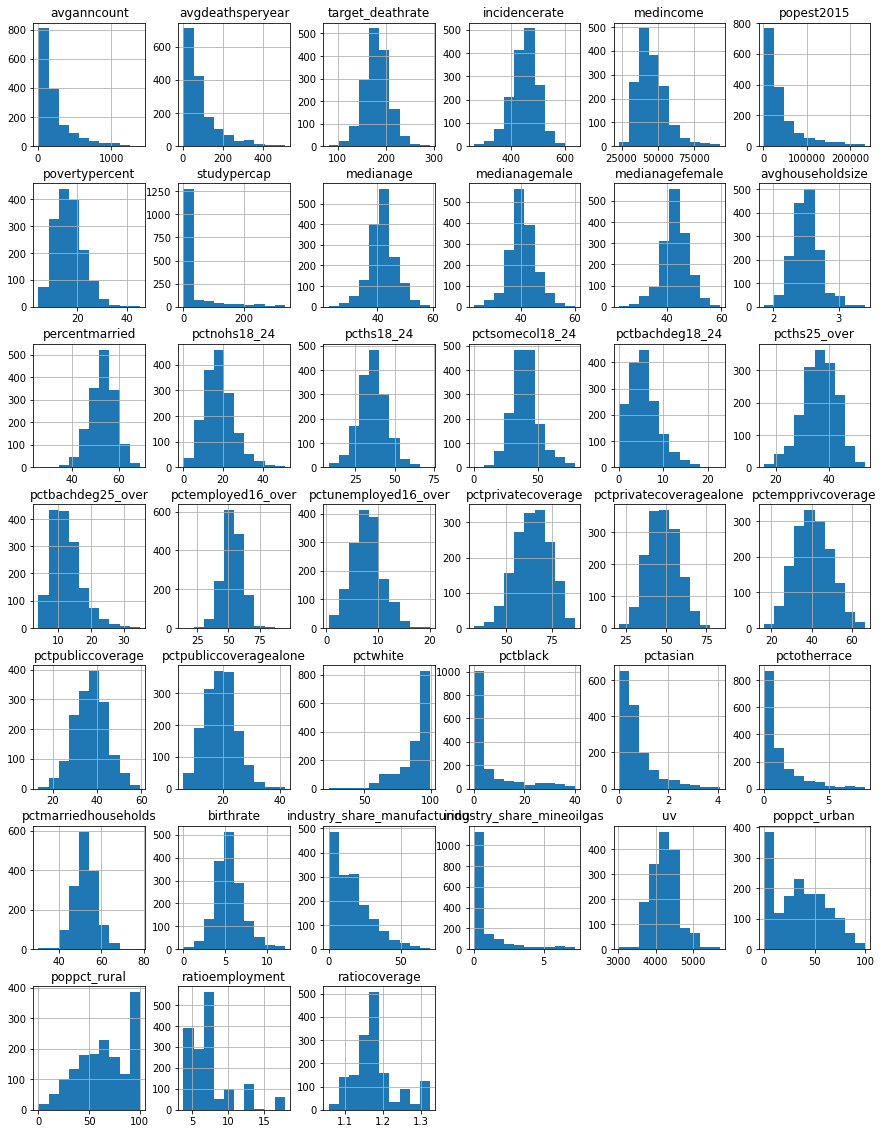

In [163]:
# check histogramms
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
numerical_o.hist(ax = ax)

In [164]:
data_main['county'].value_counts().head(10)

Washington    31
Jefferson     26
Franklin      25
Lincoln       24
Jackson       22
Madison       20
Clay          18
Union         18
Montgomery    18
Monroe        17
Name: county, dtype: int64

## 4. Linear Regression Modelling

### Import Machine Learning Libraries

In [165]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [170]:
numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3053 entries, 0 to 3052
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avganncount                   3053 non-null   float64
 1   avgdeathsperyear              3053 non-null   int64  
 2   target_deathrate              3053 non-null   float64
 3   incidencerate                 3053 non-null   float64
 4   medincome                     3053 non-null   int64  
 5   popest2015                    3053 non-null   int64  
 6   povertypercent                3053 non-null   float64
 7   studypercap                   3053 non-null   float64
 8   medianage                     3053 non-null   float64
 9   medianagemale                 3053 non-null   float64
 10  medianagefemale               3053 non-null   float64
 11  avghouseholdsize              3053 non-null   float64
 12  percentmarried                3053 non-null   float64
 13  pct

I make the decision to kick out the uv column for the first version and bring it back later.


## 4.1 X-Y-Split - Model 1

In [174]:
# Split-Up numerical into X and Y
X1 = numerical.drop(['target_deathrate','ratioemployment','ratiocoverage','uv'], axis=1)
Y1 = numerical['target_deathrate']
print(X1)
print(Y1)

      avganncount  avgdeathsperyear  incidencerate  medincome  popest2015  \
0     1397.000000               469     489.800000      61898      260131   
1      173.000000                70     411.600000      48127       43269   
2      102.000000                50     349.700000      49348       21026   
3      427.000000               202     430.400000      44243       75882   
4       57.000000                26     350.100000      49955       10321   
...           ...               ...            ...        ...         ...   
3048  1962.667684                15     453.549422      46961        6343   
3049  1962.667684                43     453.549422      48609       37118   
3050  1962.667684                46     453.549422      51144       34536   
3051  1962.667684                52     453.549422      50745       25609   
3052  1962.667684                48     453.549422      41193       37030   

      povertypercent  studypercap  medianage  medianagemale  medianagefemal

## 4.2 Train-Test-Split - Model 1

In [175]:
# train-test-split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.20, random_state=42)


## 4.3 Linear Regression - Model 1

In [176]:
# set model to Linear Regression
model1=LinearRegression()
# train the model
model1.fit(X1_train, y1_train)

LinearRegression()

## 4.4 Prediction, plotting, metrics

In [177]:
y1_pred=model1.predict(X1_test)   # model prediction
y1_pred

result=pd.DataFrame({"y_test":y1_test,"y_pred":y1_pred})

Text(0.5, 1.0, 'Test Set Residual histogram')

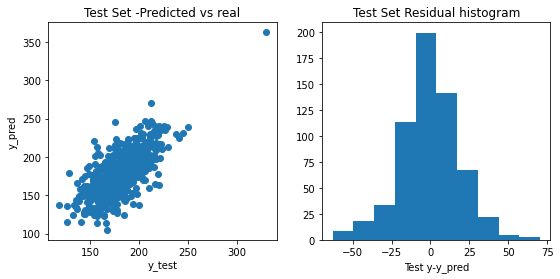

In [178]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].plot(y1_pred, y1_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y1_test - y1_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

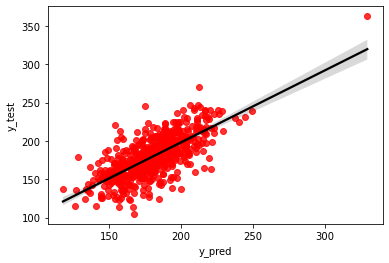

In [179]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

## Summary Model 1

### Sklearn overview

In [180]:
print('------ Lineare Regression -----')
print('Function from sklearn: y = %.3f * x + %.3f' % (model1.coef_[0], model1.intercept_))
print("Alpha: {}".format(model1.intercept_))
print("Beta: {}".format(model1.coef_[0]))
print("Training Set R² Score: {:.2f}".format(model1.score(X1_train, y1_train)))
print("Test Set R² Score: {:.2f}".format(model1.score(X1_test, y1_test)))
print("\n")

------ Lineare Regression -----
Function from sklearn: y = -0.003 * x + -76912.410
Alpha: -76912.40986225536
Beta: -0.0034606383618324132
Training Set R² Score: 0.52
Test Set R² Score: 0.51




### Stats overview

In [181]:
import statsmodels.api as sm

X_train_const_scaled = sm.add_constant(X1_train) # adding a constant

model1_OLS = sm.OLS(y1_train, X_train_const_scaled).fit()
predictions1 = model1_OLS.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X1_test) # adding a constant
print_model1 = model1_OLS.summary()
print(print_model1)

                            OLS Regression Results                            
Dep. Variable:       target_deathrate   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     75.17
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:25:20   Log-Likelihood:                -10683.
No. Observations:                2442   AIC:                         2.144e+04
Df Residuals:                    2406   BIC:                         2.165e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

C:\Users\flanc\.conda\envs\iron\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
